In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
sns.set_style("dark")

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

%pylab inline
data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

Populating the interactive namespace from numpy and matplotlib


In [62]:
data = pd.read_csv('data_cleaned.csv')
data = data[[i for i in data.columns if 'Unnamed' not in i]]
# Use only good data

# Users could enter any number for age, so let's remove the jokers
data = data[data['age'] < 71]
data.replace(-1, np.nan, inplace=True)
data = data.dropna()

# Simplify genders down to two, for convenience
data = data[(data['gender'] < 3) & (data['gender'] > 0)]
data['gender'] = np.where(data['gender'] == 1, 'man', 'woman')

# 962 rows, 39 features
data.shape

(19466, 53)

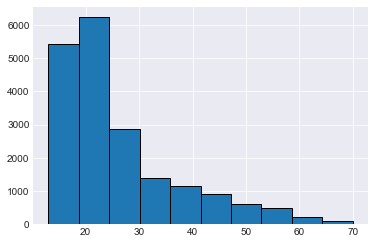

In [63]:
data['age'].hist(edgecolor='black')

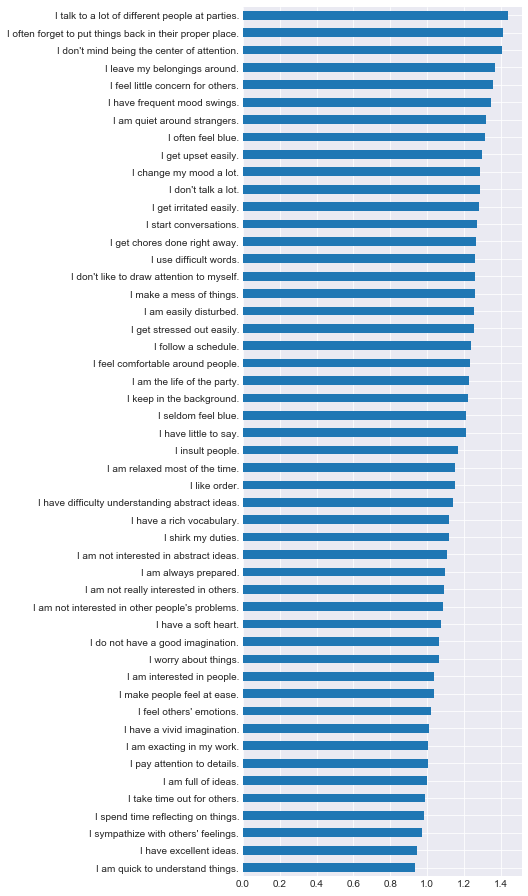

In [66]:
women.drop(['age', 'gender'], axis=1).std().sort_values().plot.barh(figsize=(5,16), grid=True)

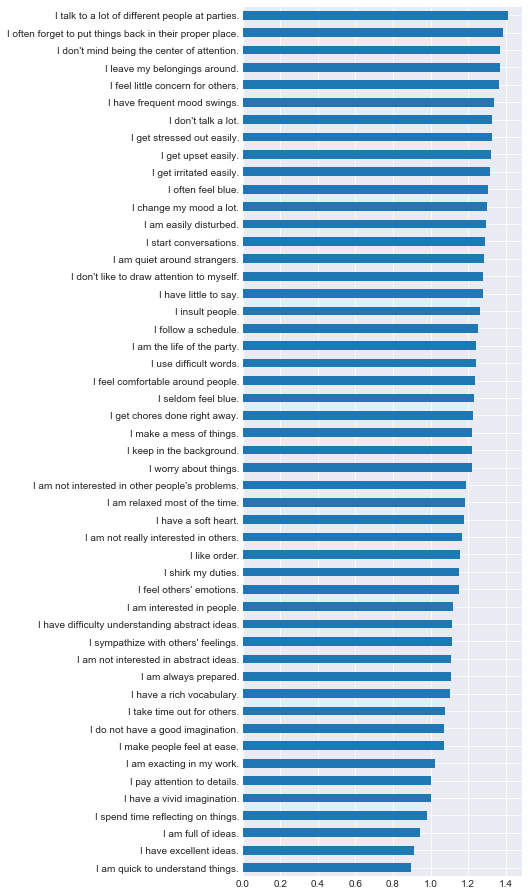

In [67]:
men.drop(['age', 'gender'], axis=1).std().sort_values().plot.barh(figsize=(5,16), grid=True)

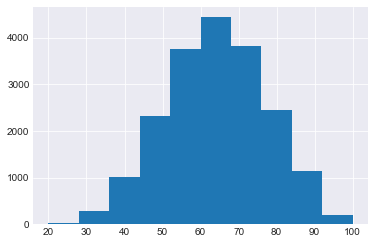

In [68]:
data['Conscientiousness'] =\
(data['I am always prepared.'] +
data['I get chores done right away.'] +
data['I like order.'] +
data['I follow a schedule.'] +
data['I am exacting in my work.'] +
(6 - data['I leave my belongings around.']) +
(6 - data['I pay attention to details.']) +
(6 - data['I make a mess of things.']) +
(6 - data['I often forget to put things back in their proper place.']) +
(6 - data['I shirk my duties.']))/.5

data['Conscientiousness'].hist()

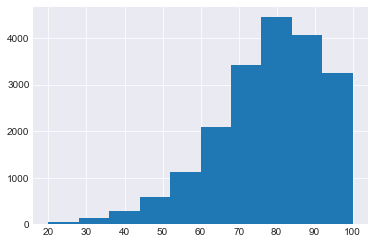

In [69]:
data['Agreeableness'] =\
(data['I take time out for others.'] +
data['I am interested in people.'] +
data["I sympathize with others' feelings."] +
data['I have a soft heart.'] +
data['I make people feel at ease.'] +
data["I feel others' emotions."] +
(6 - data["I am not interested in other people\'s problems."]) +
(6 - data["I insult people."]) +
(6 - data["I feel little concern for others."]) +
(6 - data['I am not really interested in others.']))/.5

data['Agreeableness'].hist()

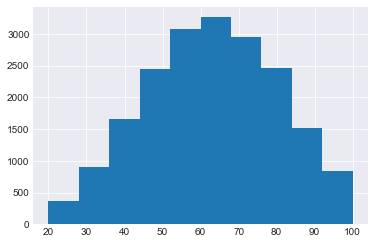

In [79]:
data['Neuroticism'] =\
(data['I get stressed out easily.'] +
data['I worry about things.'] +
data['I am easily disturbed.'] +
data['I get upset easily.'] +
data['I change my mood a lot.'] +
data['I have frequent mood swings.'] +
data['I get irritated easily.'] +
data['I often feel blue.'] +
(6 - data['I am relaxed most of the time.']) +
(6 - data['I seldom feel blue.']))/.5

data['Neuroticism'].hist()

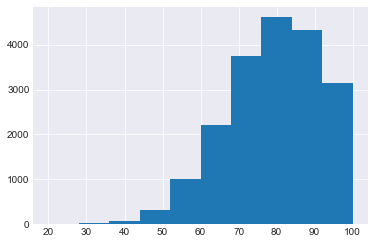

In [83]:
data['Openness'] =\
(data['I have a rich vocabulary.'] +
data['I have a vivid imagination.'] +
data['I have excellent ideas.'] +
data['I am quick to understand things.'] +
data['I use difficult words.'] +
data['I spend time reflecting on things.'] +
data['I am full of ideas.'] +
(6 - data['I have difficulty understanding abstract ideas.']) +
(6 - data['I do not have a good imagination.']) +
(6 - data['I am not interested in abstract ideas.']))/.5

data['Openness'].hist()

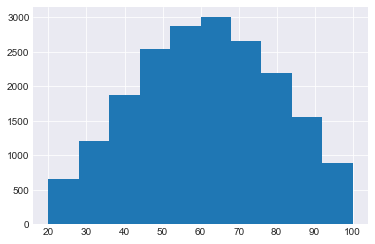

In [119]:
data['Extraversion'] =\
(data['I am the life of the party.'] +
data['I feel comfortable around people.'] +
data['I start conversations.'] +
data['I talk to a lot of different people at parties.'] +
data["I don't mind being the center of attention."] +
(6 - data["I don't like to draw attention to myself."]) +
(6 - data["I don't talk a lot."]) +
(6 - data["I have little to say."]) +
(6 - data['I am quiet around strangers.']) +
(6 - data['I keep in the background.']))/.5

data['Extraversion'].hist()

In [137]:
women = data[data.gender == 'woman']
men = data[data.gender == 'man']

# Gender Differences

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

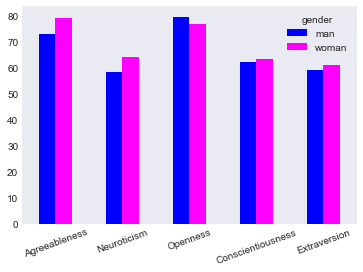

In [122]:
men_v_women = data.groupby('gender').mean()[['Agreeableness', 'Neuroticism', 'Openness',
                                             'Conscientiousness', 'Extraversion']].T

men_v_women.plot.bar(color=['blue', 'magenta'])

plt.xticks(rotation=20)

Men and women differ the most on agreeableness (which is the ability to empathize), and neuroticism (which is negative emotion). Let's graph those two.

C:\Users\Vince\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
C:\Users\Vince\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


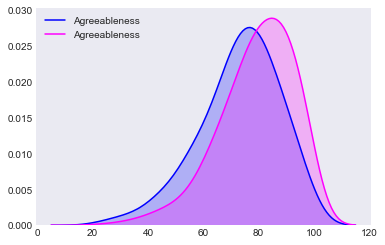

In [169]:
sns.kdeplot(men.Agreeableness, color='blue', shade=True, bw=5)
sns.kdeplot(women.Agreeableness, color='magenta', shade=True, bw=5)

In [ ]:
sns.kdeplot(men.Agreeableness, color='blue', shade=True, bw=5)
sns.kdeplot(women.Agreeableness, color='magenta', shade=True, bw=5)

## Women

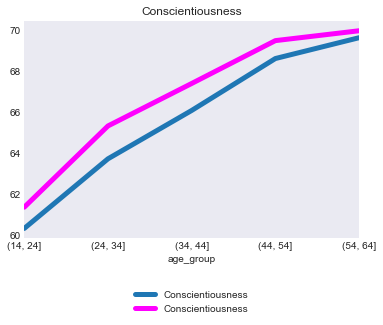

In [81]:
bins = np.arange(data.age.min()+1, data.age.max()+1, 10)
data['age_group'] = pd.Series(pd.cut(data['age'], bins=bins))

men_c = data[data['gender'] == 'man'].groupby('age_group').mean()
women_c = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_c['Conscientiousness'].plot(linewidth=5)
women_c['Conscientiousness'].plot(linewidth=5, color='magenta')

plt.title('Conscientiousness')
pylab.legend(loc=9, bbox_to_anchor=(0.5, -.2))

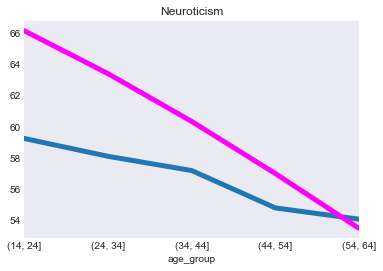

In [82]:
bins = np.arange(data.age.min()+1, data.age.max()+1, 10)
data['age_group'] = pd.Series(pd.cut(data['age'], bins=bins))

men_n = data[data['gender'] == 'man'].groupby('age_group').mean()
women_n = data[data['gender'] == 'woman'].groupby('age_group').mean()

men_n['Neuroticism'].plot(linewidth=5)
women_n['Neuroticism'].plot(linewidth=5, color='magenta')

plt.title('Neuroticism')

# Personality by country

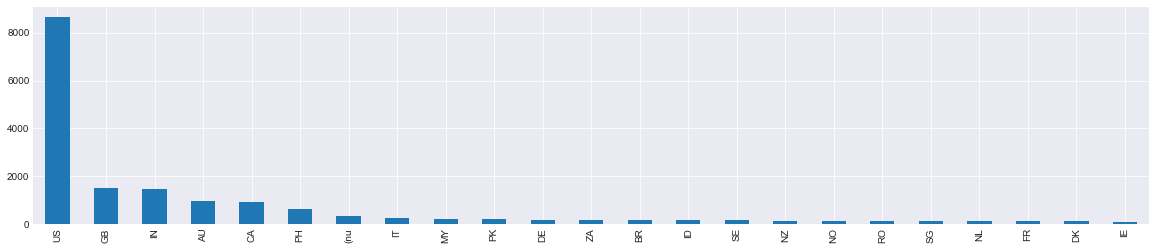

In [133]:
countries = data.country.value_counts()
countries[countries > 99].plot.bar(figsize=(20,4), grid=True)

In [11]:
from scipy.stats import ttest_ind

women_age_30 = data[(data.gender == 0) & (data.age_group.astype(str) == '(25, 35]')]['affiliative'].dropna()
women_age_60 = data[(data.gender == 0) & (data.age_group.astype(str) == '(55, 65]')]['affiliative'].dropna()

ttest_ind(women_age_30, women_age_60)

Ttest_indResult(statistic=2.4633732240448754, pvalue=0.016189277650691596)